Semi-Supervised Learning for Credit-Card Approval Project

Introduction: 
Dataset, that has been retrieved from remote server has over 90% of unlabeled data and 
at most 10% respectively. We need to predict labels of bad client for over 460000 samples, based on 
user personal information, provided. This Notebook prepares the dataset for the potential re-tranining by 
using semi-supervised learning technique

In [269]:
# let's start by loading the dataset 
import pandas, numpy
import seaborn as sns 

applications = pandas.read_csv("application_record.csv")
credit_records = pandas.read_csv("credit_record.csv")

In [270]:
# labeling data, presented in the credit records 

# Relabling Credit Records Dataset

CREDIT_MAPPING = {
    "ID": "client_id",
    "STATUS": "due_status",
    "MONTHS_BALANCE": "balance_month"
}
credit_records.rename(columns=CREDIT_MAPPING, inplace=True)

# Relabling Applications Records Dataset
APPLICATION_MAPPING = {
    "ID": "client_id",
    "CODE_GENDER": "gender",
    "FLAG_OWN_CAR": "has_car",
    "FLAG_OWN_REALTY": "has_realty",
    "CNT_CHILDREN": "total_children",
    "AMT_INCOME_TOTAL": "annual_income",
    "NAME_INCOME_TYPE": "income_category",
    "NAME_EDUCATION_TYPE": "education_category",
    "NAME_FAMILY_STATUS": "family_status",
    "NAME_HOUSING_TYPE": "living_place",
    "DAYS_BIRTH": "birthday",
    "FLAG_MOBIL": "has_mobile_phone",
    "FLAG_PHONE": "has_phone_number",
    "FLAG_WORK_PHONE": "has_work_phone",
    "FLAG_EMAIL": "has_email",
    "CNT_FAM_MEMBERS": "family_size",
    "OCCUPATION_TYPE": "job",
    'DAYS_EMPLOYED': 'days_employed',
}

applications.rename(columns=APPLICATION_MAPPING, inplace=True)


Null Values handling (Application Records)

In [271]:
applications.isnull().sum()

client_id                  0
gender                     0
has_car                    0
has_realty                 0
total_children             0
annual_income              0
income_category            0
education_category         0
family_status              0
living_place               0
birthday                   0
days_employed              0
has_mobile_phone           0
has_work_phone             0
has_phone_number           0
has_email                  0
job                   134203
family_size                0
dtype: int64

In [272]:
missing_job = 'missing'
applications['job'].fillna(value=missing_job, inplace=True)

Null Values Handling (Credit Records)

In [273]:
credit_records.isna().sum()

client_id        0
balance_month    0
due_status       0
dtype: int64

Handling outliers

In [274]:
numeric_features = applications.select_dtypes(include='number').columns
numeric_features

Index(['client_id', 'total_children', 'annual_income', 'birthday',
       'days_employed', 'has_mobile_phone', 'has_work_phone',
       'has_phone_number', 'has_email', 'family_size'],
      dtype='object')

Total Children

<Axes: xlabel='total_children'>

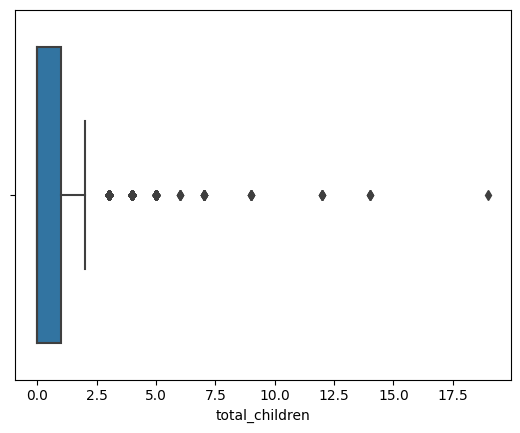

In [275]:
sns.boxplot(x=applications['total_children'])

In [276]:
low, high = numpy.percentile(applications['annual_income'], [25, 75])
iqr = (high - low)
low_fence, high_fence = low - (1.5 * iqr), high + (1.5 * iqr)

outliers = applications.loc[
    (applications["annual_income"] > high_fence) | (applications['annual_income'] < low_fence)
]


print('outliers: ', outliers.shape[0])
print('total samples: ', len(applications))



outliers:  19108
total samples:  438557


Family Size

<Axes: xlabel='family_size'>

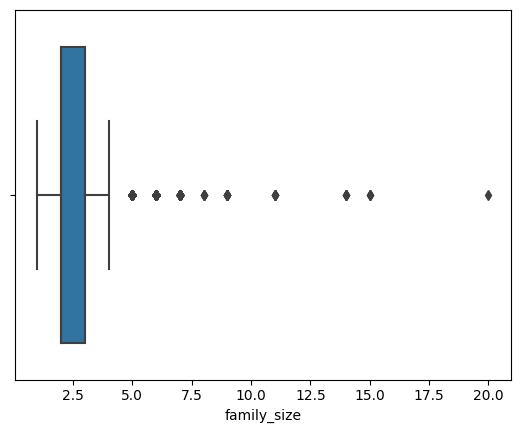

In [277]:
sns.boxplot(x=applications['family_size'])

Feature Engineering

Application Record Features

In [278]:
import math 

applications = applications.drop_duplicates(subset=["client_id"], keep='last', inplace=False)

applications['age'] = applications['birthday'].apply(lambda day: math.floor(abs(day) / 365))
applications['employed'] = applications['days_employed'].apply(lambda days: True if days < 0 else False)

dup_clients = applications['client_id'].value_counts().to_frame("number_of_apps").reset_index()
applications['exp_applicant'] = numpy.where(dup_clients['number_of_apps'] > 1, True, False)

applications.drop(columns=['birthday', 'days_employed'], inplace=True)

def create_married_feature(applications: pandas.DataFrame):

    non_mar_statuses = set(['Single / not married', 'Separated', 'Widow'])
    applications['family_status'] = applications['family_status'].apply(
        func=lambda status: True if status not in non_mar_statuses else False
    )
    return applications.rename(columns={'family_status': 'married'}, inplace=False)


def create_gender_feature(applications: pandas.DataFrame):

    encoded_data = pandas.get_dummies(
        applications['gender']
    ).rename(columns={'F': 'Female', 'M': 'Male'})

    applications = pandas.concat([applications, encoded_data], axis=1)
    applications.drop(columns=['gender'], inplace=True)
    return applications

applications = create_married_feature(applications)
applications = create_gender_feature(applications)

In [279]:
# Cleansing credit records dataset 
DUE_DATATYPES = {
    "0": 0,
    "1": 0,
    "2": 1,
    "3": 1,
    "4": 1,
    "5": 1,
    "X": 0,
    "C": 0
}
credit_records['due_status'] = credit_records['due_status'].map(lambda item: DUE_DATATYPES[item])

Credit Record Features

In [280]:
# introducing credit records features (bad client status)
credit_features = pandas.DataFrame()
credit_features['client_id'] = credit_records['client_id'].unique()
credit_features['overdues'] = pandas.Series(credit_records.groupby('client_id')['due_status'].sum().to_numpy())
credit_features['credit_window'] = numpy.abs(credit_records['balance_month'].min())
credit_features['overdue_perc'] = numpy.round(credit_features['overdues'] / credit_features['credit_window'], 2)

# annotating bad client status
credit_features['bad_client'] = numpy.where(credit_features['overdues'] > 0, True, False)
credit_features = credit_features[['client_id', 'bad_client']]

credit_features['bad_client'].value_counts()

bad_client
False    45318
True       667
Name: count, dtype: int64

Merging tables together

In [281]:
merged_dataset = applications.merge(credit_features, on='client_id', how='left')
merged_dataset

,client_id,has_car,has_realty,total_children,annual_income,income_category,education_category,married,living_place,has_mobile_phone,...,has_phone_number,has_email,job,family_size,age,employed,exp_applicant,Female,Male,bad_client
0,5008804,Y,Y,0,427500.0,Working,Higher education,True,Rented apartment,1,...,0,0,missing,2.0,32,True,False,False,True,False
1,5008805,Y,Y,0,427500.0,Working,Higher education,True,Rented apartment,1,...,0,0,missing,2.0,32,True,False,False,True,False
2,5008806,Y,Y,0,112500.0,Working,Secondary / secondary special,True,House / apartment,1,...,0,0,Security staff,2.0,58,True,False,False,True,False
3,5008808,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,False,House / apartment,1,...,1,1,Sales staff,1.0,52,True,False,True,False,False
4,5008809,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,False,House / apartment,1,...,1,1,Sales staff,1.0,52,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,N,Y,0,135000.0,Pensioner,Secondary / secondary special,False,House / apartment,1,...,0,0,missing,1.0,62,False,False,False,True,NaN
438506,6840222,N,N,0,103500.0,Working,Secondary / secondary special,False,House / apartment,1,...,0,0,Laborers,1.0,43,True,False,True,False,NaN
438507,6841878,N,N,0,54000.0,Commercial associate,Higher education,False,With parents,1,...,0,0,Sales staff,1.0,22,True,False,True,False,NaN
438508,6842765,N,Y,0,72000.0,Pensioner,Secondary / secondary special,True,House / apartment,1,...,0,0,missing,2.0,59,False,False,True,False,NaN


<Axes: xlabel='annual_income'>

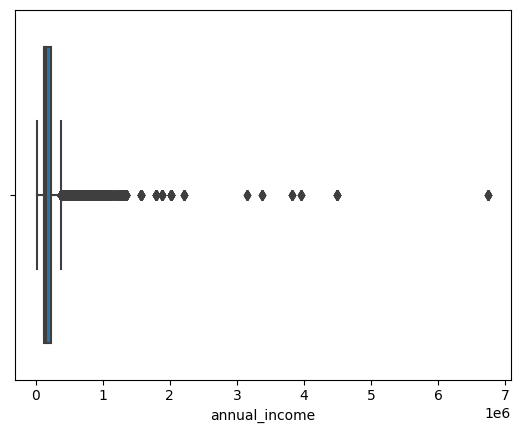

In [282]:
sns.boxplot(x=applications['annual_income'])

In [283]:
low, high = numpy.percentile(merged_dataset['annual_income'], [25, 75])
iqr = (high - low)
low_fence, high_fence = low - (1.5 * iqr), high + (1.5 * iqr)

outliers = merged_dataset.loc[
    (merged_dataset["annual_income"] > high_fence) | (merged_dataset['annual_income'] < low_fence)
]

print('outliers: ', outliers.shape[0])
print('total samples: ', len(merged_dataset))


outliers:  19102
total samples:  438510


In [284]:
# percentage of positive classes 

pos_perc = outliers['bad_client'].value_counts()
pos_perc

bad_client
False    1501
True       28
Name: count, dtype: int64

Dropping outliers

In [285]:
merged_dataset = merged_dataset.loc[
    (merged_dataset['annual_income'] < high_fence) & (merged_dataset['annual_income'] > low_fence)
]
merged_dataset['bad_client'].value_counts()

bad_client
False    34340
True       588
Name: count, dtype: int64

Preparing dataset

In [286]:
def encode_bool_features(dataset: pandas.DataFrame):
    """
    Function standardizes boolean features to the following format 
        True: (Y, 1)
        False: (N, 0)
    Args:
        dataset: pandas.DataFrame object, containing boolean features
    """
    bool_features = ['has_car', 'has_realty', 'has_phone_number', 'has_email', 'has_mobile_phone', 'has_work_phone']
    if not all(feature in dataset.columns for feature in bool_features): return 

    for feature in bool_features:
        dataset[feature] = dataset[feature].map(
            {
                'Y': True,
                'N': False,
                1: True,
                0: False
            }
        )

def encode_bad_client_status(dataset: pandas.DataFrame):
    """
    Function encodes bad client status by applying new category called 'missing'
    """

encode_bool_features(merged_dataset)

/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_29455/2245522233.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[feature] = dataset[feature].map(
/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_29455/2245522233.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[feature] = dataset[feature].map(
/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_29455/2245522233.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Dataset Splitting (training, testing)

In [287]:
from sklearn.model_selection import train_test_split 

labeled_data = merged_dataset[merged_dataset['bad_client'].notnull()]
unlabeled_data = merged_dataset[merged_dataset['bad_client'].isnull()]

X_labeled = labeled_data.drop(columns=['bad_client'], inplace=False)
Y_labeled = labeled_data['bad_client']


x_train, x_test, y_train, y_test = train_test_split(
    X_labeled, Y_labeled, stratify=Y_labeled, test_size=0.45, random_state=42
)

training_set = pandas.concat([x_train, y_train], axis=1)
testing_set = pandas.concat([x_test, y_test], axis=1)

print(len(training_set), len(testing_set))

19210 15718


Removing Redundant and Unncessesary Features

In [288]:
for dataset in [
    training_set, testing_set, unlabeled_data
]:
    dataset.drop(
        columns=[
            "client_id",
            "job",
            'has_work_phone',
            'married',
            'family_size',
            'Male',
            'Female',
            'has_phone_number',
            'has_email',
            'education_category',
            'income_category'
        ], inplace=True
    )

/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_29455/2452667284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(


Standardizing data before applying Label Propagation Technique

In [289]:
# before training models, we need to make sure, that numeric data falls in the same scales 
# otherwise some machine learning algorithms might end up having poor prediction ability 

from sklearn import preprocessing

def get_scaled_dataset(feature_dataset: pandas.DataFrame, scaler: preprocessing.StandardScaler=None) -> pandas.DataFrame:
    """
    Function scales numeric features using Standard Scaler 
    std = 1, mean = 0

    Args:
        feature_dataset: dataset for scaling
        scaler: Optional - pre-trained scaler if available
        
    Returns:
        dataset with scaled numeric data
    """
    numeric_features = feature_dataset.select_dtypes(include='number').columns
    other_features = feature_dataset.drop(columns=numeric_features, inplace=False).columns

    if scaler is None:
        scaler = preprocessing.StandardScaler()
        data = scaler.fit_transform(feature_dataset[numeric_features])
    else:
        data = scaler.transform(feature_dataset[numeric_features])

    df = pandas.DataFrame(data=data, columns=numeric_features, index=feature_dataset.index)
    
    return scaler, pandas.concat([df, feature_dataset[other_features]], axis=1)

In [290]:
scaler, training_set = get_scaled_dataset(training_set)

_, testing_set = get_scaled_dataset(testing_set, scaler)

_, unlabeled_data = get_scaled_dataset(unlabeled_data, scaler)

Feature Encoding

In [291]:
from sklearn.preprocessing import OrdinalEncoder

def encode_living_place_feature(dataset: pandas.DataFrame):
    """
    Function encodes `living place` dataset using Ordinal Encoding 
    
    Args:
        dataset: pandas.DataFrame object, containing living_place feature
    """
    if not 'living_place' in dataset.columns: return 
    living_categories = [
        'Co-op apartment',
        'Office apartment',
        'Municipal apartment',
        'Rented apartment', 
        'House / apartment',
        'With parents',
    ]
    encoder = OrdinalEncoder(dtype=numpy.int8, categories=[living_categories])
    dataset['living_place'] = encoder.fit_transform(dataset[['living_place']])


def encode_dataset(merged_dataset: pandas.DataFrame):
    """
    Encodes all feature dataset using appropriate
    feature encoding techniques 
    """
    encode_living_place_feature(merged_dataset)
    return merged_dataset

print(len(training_set), len(testing_set))

training_set = encode_dataset(training_set)
testing_set = encode_dataset(testing_set)

unlabeled_data = encode_dataset(unlabeled_data)


19210 15718


In [292]:
unlabeled_data

,total_children,annual_income,age,has_car,has_realty,living_place,has_mobile_phone,employed,exp_applicant,bad_client
12,-0.575000,1.371474,0.238968,True,True,4,True,True,False,NaN
26,0.757418,-0.854214,-1.145872,False,True,4,True,True,False,NaN
43,-0.575000,-0.854214,1.104492,True,True,4,True,True,False,NaN
44,-0.575000,-0.854214,1.104492,True,True,4,True,True,False,NaN
45,-0.575000,-0.854214,1.104492,True,True,4,True,True,False,NaN
...,...,...,...,...,...,...,...,...,...,...
438505,-0.575000,-0.536259,1.623807,False,True,4,True,False,False,NaN
438506,-0.575000,-0.981396,-0.020690,False,False,4,True,True,False,NaN
438507,-0.575000,-1.680898,-1.838291,False,False,5,True,True,False,NaN
438508,-0.575000,-1.426534,1.364150,False,True,4,True,False,False,NaN


Semi Supervised Learning Analysis

In [293]:
# Separating data into labeled and unlabeled datasets 

labeled_data = training_set
unlabeled_data = unlabeled_data

In [294]:
from sklearn.model_selection import train_test_split 
Xl_data, Yl_data = labeled_data.drop(columns=['bad_client']), labeled_data['bad_client']

X_train, X_validation, Y_train, Y_validation = train_test_split(Xl_data, Yl_data, stratify=Yl_data, test_size=0.3)

# Splitting into training and validation sets 

training_tuple = (X_train, Y_train.astype(numpy.bool_))
validation_tuple = (X_validation, Y_validation.astype(numpy.bool_))


Appyling Stratified Sampling to Unlabeled Data

In [295]:
# splitting unlabeled data
X_unlabeled_data = unlabeled_data.drop(columns=['bad_client'], inplace=False)

X_unlabeled_data, _ = train_test_split(X_unlabeled_data, test_size=0.8, random_state=42)

len(X_unlabeled_data)

76896

Semi Supervised Learning (Tuning Label Propagation Model)

In [296]:
# from sklearn.semi_supervised import LabelPropagation
# import sklearn.exceptions, logging
# from sklearn.model_selection import GridSearchCV, StratifiedKFold


# Logger = logging.getLogger(__name__)

# prop_params = {
#     'kernel': ['rbf', 'knn', 'rbf', 'linear', 'poly', 'sigmoid'],
#     'gamma': [0.1, 1, 10],
#     'n_neighbors': numpy.arange(start=9, stop=20, step=2).tolist(),
# }

# prop = LabelPropagation()

# new_cvs = GridSearchCV(
#     estimator=prop,
#     param_grid=prop_params,
#     n_jobs=-1,
#     cv=StratifiedKFold(n_splits=10)
# )

# # training classifier propagation using training set 
# new_cvs.fit(training_tuple[0], training_tuple[1])

# prop = new_cvs.best_estimator_


Evaluating Label Propagation model using validation set

In [297]:
# from sklearn.metrics import classification_report

# def predict_evaluation_set(X_data):
#     """
#     Function predicts target variable (bad_client) based on testing dataset
#     Method used exceptionally for evaluation purposes to get an Idea of how great 
#     Label Propagation works 
    
#     Args:
#         testing_tuple: 
#             Tuple Object, containg X and Y variables 
            
#             testing_tuple[0] - X variables 
#             testing_tuple[1] - Y variable
#     """
#     try:
#         return prop.predict(X_data)
        
#     except(sklearn.exceptions.NotFittedError) as fit_err:
#         Logger.debug("unlabeled data is invalid. %s" % fit_err)
#         raise RuntimeError("Failed to label data")

# y_pred = predict_evaluation_set(validation_tuple[0])

# classification_report(
#     y_true=validation_tuple[1],
#     y_pred=y_pred
# )

Predicting Unlabeled data using optimized Label Propagation Model

In [298]:
# unlabeled_metrics = pandas.DataFrame()

# unlabeled_metrics['prob'] = numpy.array(prop.predict_proba(X_unlabeled_data))[:, 1]
# unlabeled_metrics['value'] = prop.predict(X_unlabeled_data)

# unlabeled_metrics

# unlabeled_metrics['value'].value_counts()

Setting up missing labels

In [299]:
# unlabeled_metrics.set_index(unlabeled_data.index, inplace=True)

# unlabeled_data.loc[:, 'bad_client'] = unlabeled_metrics['value']

Creating new training set (merging labeled data and existing training set)

In [300]:
# training_set = pandas.concat([training_set, unlabeled_data], axis=0)
training_set 

,total_children,annual_income,age,has_car,has_realty,living_place,has_mobile_phone,employed,exp_applicant,bad_client
39071,0.757418,0.036061,0.152415,False,True,4,True,True,False,False
22625,0.757418,-0.536259,-0.540004,False,True,4,True,True,False,False
24349,-0.575000,0.735563,1.796912,False,True,4,True,False,False,False
37037,-0.575000,-1.490125,1.623807,True,True,4,True,False,False,False
13149,-0.575000,0.290426,1.191045,False,True,4,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...
21392,-0.575000,0.417608,-1.232424,True,True,4,True,True,False,False
43002,-0.575000,0.417608,0.585178,False,True,4,True,True,False,False
37436,2.089836,-0.854214,-0.540004,False,True,4,True,True,False,False
26432,0.757418,-0.154712,-0.799662,False,False,4,True,True,False,False


Datatypes Assigning

In [301]:
def set_datatypes(df):
    # Numeric Data
    df['total_children'] = df['total_children'].astype(numpy.int8)
    df['annual_income'] = df['annual_income'].astype(numpy.int64)
    df['age'] = df['age'].astype(numpy.int8)

    # Boolean Data
    df['employed'] = df['employed'].astype(numpy.bool_)
    df['exp_applicant'] = df['exp_applicant'].astype(numpy.bool_)

    # Categorical Data
    df['living_place'] = df['living_place'].astype(numpy.int8)
    df['bad_client'] = df['bad_client'].astype(numpy.bool_)

set_datatypes(training_set)
set_datatypes(testing_set)

In [302]:
training_set.isna().sum()

total_children      0
annual_income       0
age                 0
has_car             0
has_realty          0
living_place        0
has_mobile_phone    0
employed            0
exp_applicant       0
bad_client          0
dtype: int64

Class Imbalance Fix

In [303]:
from imblearn.over_sampling import SMOTE 

x_data, y_data = training_set.drop(columns=['bad_client']), training_set['bad_client']

def balance_dataset(X_data: pandas.DataFrame, Y_data: pandas.Series):
    """
    Function uses SMOTE (Sensitivity Class Over Sampling Technique) to address class imbalance issue
    
    Args:
        X_data: pandas.DataFrame object containing independent features
        Y_data: pandas.Series object representing target variable
    """
    encoder = SMOTE(k_neighbors=5, random_state=42)
    x_res, y_res = encoder.fit_resample(X=X_data, y=Y_data)
    return pandas.concat([x_res, y_res], axis=1)


training_set = balance_dataset(X_data=x_data, Y_data=y_data)

Checking balance

<Axes: xlabel='bad_client', ylabel='count'>

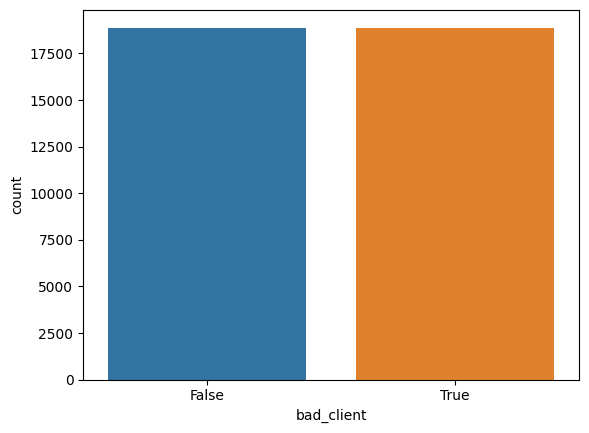

In [304]:
sns.countplot(data=training_set, x='bad_client')

Splitting training set using Stratified Sampling

In [305]:
# X_train, Y_train = training_set.drop(columns=['bad_client']), training_set['bad_client']

# x_train, _, y_train, _ = train_test_split(
#         X_train, Y_train, 
#         test_size=0.7, stratify=Y_train, 
#         random_state=42,
# )

# training_set = pandas.concat([x_train, y_train], axis=1)

In [306]:
training_set['bad_client'].value_counts()

bad_client
False    18887
True     18887
Name: count, dtype: int64

In [307]:
testing_set['bad_client'].value_counts()

bad_client
False    15453
True       265
Name: count, dtype: int64

In [308]:
print(len(training_set), len(testing_set))

37774 15718


Saving new datasets to a CSV Files

In [309]:
training_set.to_csv("training_set.csv")
testing_set.to_csv('testing_set.csv')